## Vaccinations

In [1]:
%reset -f

In [2]:
%pip install ..

Processing /home/sean/Workspaces/contact-networks
  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for contact-networks, since package 'wheel' is not installed.
  Attempting uninstall: contact-networks
    Found existing installation: contact-networks 0.1.0
    Uninstalling contact-networks-0.1.0:
      Successfully uninstalled contact-networks-0.1.0
  Running setup.py install for contact-networks ... done
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from contact_networks import graph_metrics, sir_propagation
from contact_networks import utils

In [4]:
colors = [
    '#E69F00',  # Soft Orange
    '#56B4E9',  # Sky Blue
    '#009E73',  # Teal Green
    '#CC79A7',  # Muted Purple
    '#F0E442',  # Golden Yellow
    '#0072B2',  # Slate Blue
    '#D55E00',  # Coral Red
]

# Set the color cycle permanently in rcParams
mpl.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

In [5]:
data = utils.load_data()

In [6]:
beta = 4e-4
mu = lambda delta, k: delta * beta / k
del_t = (5e-3) / beta
stop_time = np.inf
ks = [5,4,3,2,1]
n_vaccinated = 20
p_vaccinated = 0.2
n_samples = 100

In [7]:
def get_proportions_recovered(adj_matrix, delta, k, vaccination_method='none'):
    n_nodes = adj_matrix.shape[0]
    proportions_recovered = np.zeros(n_samples)

    # calculate basic reproduction number 
    dbar = graph_metrics.average_degree(adj_matrix)
    rho0 = k * dbar / delta

    p_vaccinated = 1 - 1/rho0 # herd immunity
    p_vaccinated *= 0.8
    p_vaccinated = np.min([p_vaccinated, 1.0])
    n_vaccinated = np.max([int(n_nodes * p_vaccinated), 0])

    # find the highest degree nodes if vaccination_method == 'targeted'
    if vaccination_method in ['none', 'random']:
        pass
    elif vaccination_method == 'targeted':
        degrees = graph_metrics.degree_distribution(adj_matrix)
        vaccinated = np.array([], dtype=int) if n_vaccinated == 0 else np.argsort(degrees)[-n_vaccinated:][::-1]
    else:
        raise ValueError(f'Unrecognized vaccination_method "{vaccination_method}"')
    
    for idx in range(n_samples):
        # vaccinate a subset of nodes
        match vaccination_method:
            case 'none':
                vaccinated = np.array([], dtype=int)
            case 'random':
                vaccinated = np.random.choice(n_nodes, size=n_vaccinated, replace=False)
            case 'targeted':
                pass # vaccinated is already correctly defined

        # infect a random unvaccinated node
        unvaccinated = np.setdiff1d(np.arange(n_nodes), vaccinated)
        initial_infected = np.random.choice(unvaccinated)

        # run the simulation
        _, _, recovered = sir_propagation.sir_propagation(
            adj_matrix, 
            infection_rate=beta, 
            recovery_rate=mu(delta, k),
            step_size=del_t,
            stop_time=stop_time,
            initial_infected=initial_infected,
            initial_recovered=vaccinated
        )

        # append the proportion recovered
        if vaccination_method != 'none':
            proportion_recovered = (recovered.size-n_vaccinated) / n_nodes # don't count the vaccinated nodes
        else:
            proportion_recovered = recovered.size / n_nodes
        proportions_recovered[idx] = proportion_recovered

    # calculate basic reproduction number 
    dbar = graph_metrics.average_degree(adj_matrix)
    rho0 = k * dbar / delta
    
    return proportions_recovered, rho0


def get_proportions_major(adj_matrix, delta, ks, vaccination_method='none'):
    proportions_major = np.zeros(ks.size)
    rho0s = np.zeros(ks.size)
    for idx, k in enumerate(ks):
        proportions_recovered, rho0 = get_proportions_recovered(
            adj_matrix=adj_matrix,
            delta=delta,
            k=k,
            vaccination_method=vaccination_method
        )
        rho0s[idx] = rho0
        proportion_major = np.count_nonzero(proportions_recovered > 0.2) / proportions_recovered.size
        proportions_major[idx] = proportion_major
    return proportions_major, rho0s

In [8]:
def plot_ratios(ax, rho0s, ratios, label):
    ax.plot(
        rho0s, 
        ratios, 
        linewidth=1, 
        marker='o',
        label=label
    )


def plot_ax_ratios(ax, adj_matrix, delta, ks):
    proportions_major_none, rho0s = get_proportions_major(
        adj_matrix=adj_matrix,
        delta=delta, 
        ks=ks,
        vaccination_method='none'
    )
    proportions_major_random, _ = get_proportions_major(
        adj_matrix=adj_matrix,
        delta=delta, 
        ks=ks,
        vaccination_method='random'
    )
    proportions_major_targeted, _ = get_proportions_major(
        adj_matrix=adj_matrix,
        delta=delta, 
        ks=ks,
        vaccination_method='targeted'
    )

    ratios_random = np.divide(proportions_major_random, proportions_major_none)
    ratios_targeted = np.divide(proportions_major_targeted, proportions_major_none)

    plot_ratios(
        ax=ax,
        rho0s=rho0s,
        ratios=ratios_random,
        label='Random vaccination'
    )
    plot_ratios(
        ax=ax,
        rho0s=rho0s,
        ratios=ratios_targeted,
        label='Targeted vaccination'
    )

    # annotations
    ax.axhline(1, color='k', linestyle='--')
    ax.set_ylabel("Ratio")
    ax.set_xlabel(r"$\rho_0$")
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    data_max = np.max([ratios_random.max(), ratios_targeted.max()])
    ax.set_ylim([0,np.max([1.2, data_max + 0.1])])


def plot_subfig_ratios(fig, X, ks):
    axes = fig.subplots(1, 2, sharey=False)
    axes = axes.ravel()
    plot_ax_ratios(
        ax=axes[0],  
        adj_matrix=X['face-to-face'], 
        delta=10, 
        ks=ks
    )
    n_nodes = X['face-to-face'].shape[0]
    axes[0].set_title(f'Face-to-Face Network, |V|={n_nodes}')
    plot_ax_ratios(
        ax=axes[1],
        adj_matrix=X['co-present'],
        delta=50,
        ks=ks
    )
    n_nodes = X['co-present'].shape[0]
    axes[1].set_title(f'Co-present Network, |V|={n_nodes}')


def plot_supfig_ratios(data, ks):
    ks = np.array(ks)

    fig = plt.figure(layout='constrained', figsize=(15,20))
    subfigs = fig.subfigures(6, 1, hspace=0)

    for subfig, (key, X) in zip(subfigs.ravel(), data.items()):
        plot_subfig_ratios(subfig, X, ks)
        subfig.suptitle(f"{key} Dataset", fontsize=10, fontweight='bold')

    fig.suptitle(r'Ratio of major epidemics with/without vaccination')

    return fig

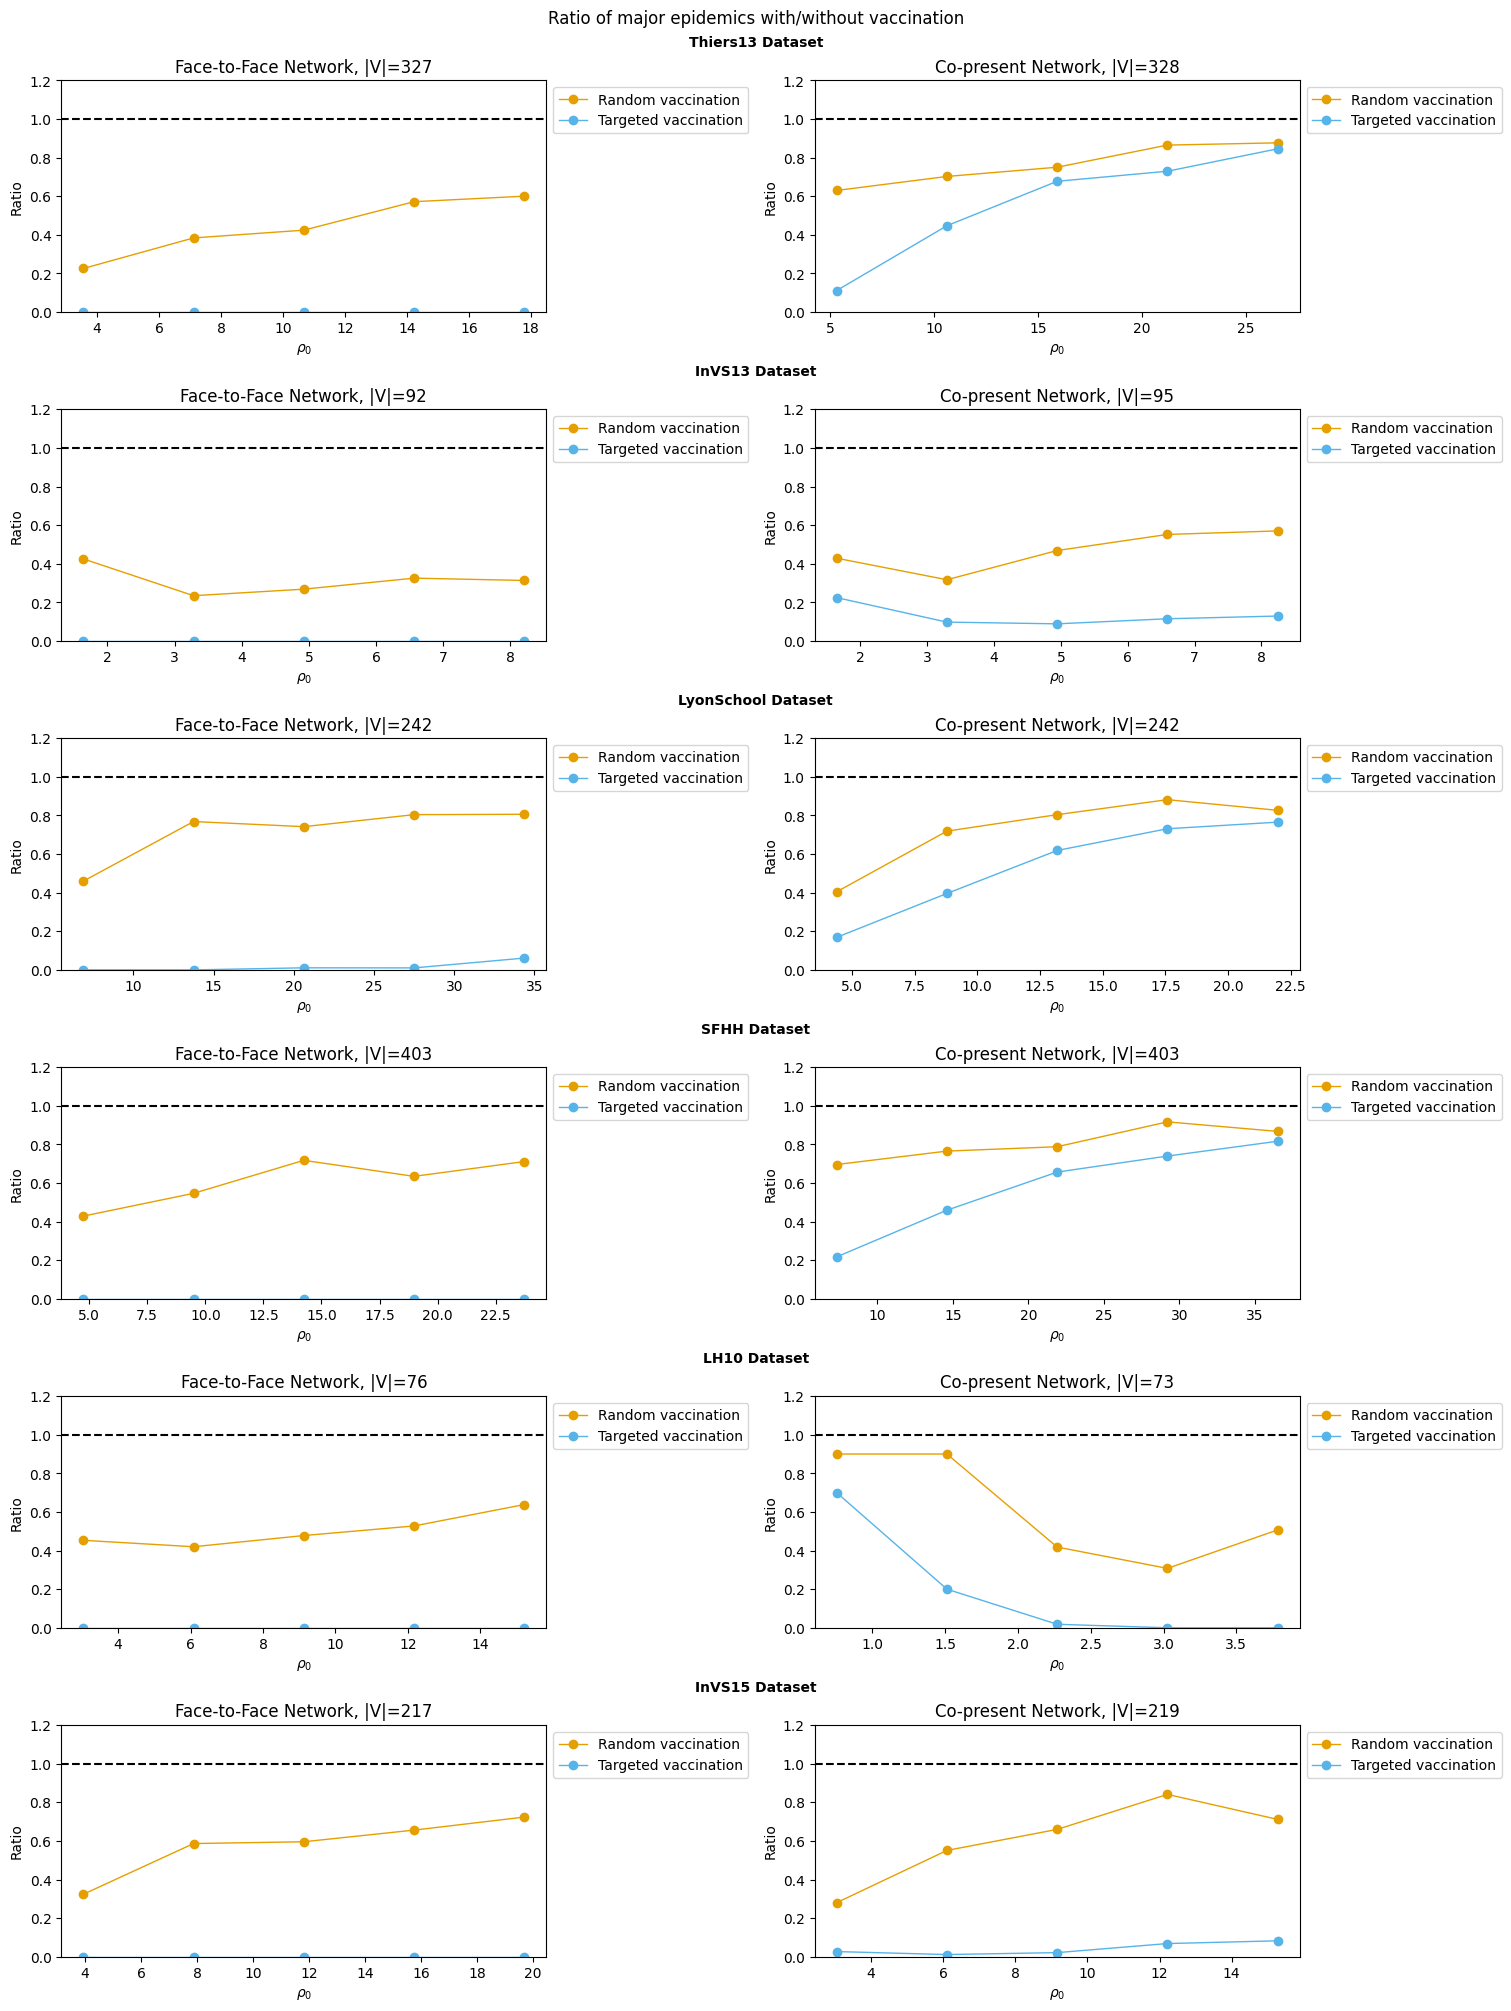

In [9]:
plot_supfig_ratios(data, ks)
plt.show()

In [10]:
def get_counts_recovered(adj_matrix, delta, k, vaccination_method='none'):
    n_nodes = adj_matrix.shape[0]
    counts_recovered = np.zeros(n_samples)

    # calculate basic reproduction number 
    dbar = graph_metrics.average_degree(adj_matrix)
    rho0 = k * dbar / delta

    p_vaccinated = 1 - 1/rho0 # herd immunity
    p_vaccinated *= 0.8
    p_vaccinated = np.min([p_vaccinated, 1.0])
    n_vaccinated = np.max([int(n_nodes * p_vaccinated), 0])

    # find the highest degree nodes if vaccination_method == 'targeted'
    if vaccination_method in ['none', 'random']:
        pass
    elif vaccination_method == 'targeted':
        degrees = graph_metrics.degree_distribution(adj_matrix)
        vaccinated = np.array([], dtype=int) if n_vaccinated == 0 else np.argsort(degrees)[-n_vaccinated:][::-1]
    else:
        raise ValueError(f'Unrecognized vaccination_method "{vaccination_method}"')
    
    for idx in range(n_samples):
        # vaccinate a subset of nodes
        match vaccination_method:
            case 'none':
                vaccinated = np.array([], dtype=int)
            case 'random':
                vaccinated = np.random.choice(n_nodes, size=n_vaccinated, replace=False)
            case 'targeted':
                pass # vaccinated is already correctly defined

        # infect a random unvaccinated node
        unvaccinated = np.setdiff1d(np.arange(n_nodes), vaccinated)
        initial_infected = np.random.choice(unvaccinated)

        # run the simulation
        _, _, recovered = sir_propagation.sir_propagation(
            adj_matrix, 
            infection_rate=beta, 
            recovery_rate=mu(delta, k),
            step_size=del_t,
            stop_time=stop_time,
            initial_infected=initial_infected,
            initial_recovered=vaccinated
        )

        # append the proportion recovered
        if vaccination_method != 'none':
            count_recovered = (recovered.size-n_vaccinated) # don't count the vaccinated nodes
        else:
            count_recovered = recovered.size / n_nodes

        if count_recovered > 0.2 * n_nodes:
            counts_recovered[idx] = count_recovered
    
    return counts_recovered, rho0


def get_median_counts_recovered(adj_matrix, delta, ks, vaccination_method='none'):
    median_counts_recovered = np.zeros(ks.size)
    rho0s = np.zeros(ks.size)
    for idx, k in enumerate(ks):
        counts_recovered, rho0 = get_proportions_recovered(
            adj_matrix=adj_matrix,
            delta=delta,
            k=k,
            vaccination_method=vaccination_method
        )
        rho0s[idx] = rho0
        median_count_recovered = np.median(counts_recovered)
        median_counts_recovered[idx] = median_count_recovered
    return median_counts_recovered, rho0s

In [11]:
def plot_medians(ax, rho0s, ratios, label):
    ax.plot(
        rho0s, 
        ratios, 
        linewidth=1, 
        marker='o',
        label=label
    )


def plot_ax_medians(ax, adj_matrix, delta, ks):
    median_counts_recovered_none, rho0s = get_median_counts_recovered(
        adj_matrix=adj_matrix,
        delta=delta, 
        ks=ks,
        vaccination_method='none'
    )
    median_counts_recovered_random, _ = get_median_counts_recovered(
        adj_matrix=adj_matrix,
        delta=delta, 
        ks=ks,
        vaccination_method='random'
    )
    median_counts_recovered_targeted, _ = get_median_counts_recovered(
        adj_matrix=adj_matrix,
        delta=delta, 
        ks=ks,
        vaccination_method='targeted'
    )

    ratios_random = np.divide(median_counts_recovered_random, median_counts_recovered_none)
    ratios_targeted = np.divide(median_counts_recovered_targeted, median_counts_recovered_none)

    plot_ratios(
        ax=ax,
        rho0s=rho0s,
        ratios=ratios_random,
        label='Random vaccination'
    )
    plot_ratios(
        ax=ax,
        rho0s=rho0s,
        ratios=ratios_targeted,
        label='Targeted vaccination'
    )

    # annotations
    ax.axhline(1, color='k', linestyle='--')
    ax.set_ylabel("Ratio")
    ax.set_xlabel(r"$\rho_0$")
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    data_max = np.max([ratios_random.max(), ratios_targeted.max()])
    ax.set_ylim([0,np.max([1.2, data_max + 0.1])])


def plot_subfig_medians(fig, X, ks):
    axes = fig.subplots(1, 2, sharey=False)
    axes = axes.ravel()
    plot_ax_ratios(
        ax=axes[0],  
        adj_matrix=X['face-to-face'], 
        delta=10, 
        ks=ks
    )
    n_nodes = X['face-to-face'].shape[0]
    axes[0].set_title(f'Face-to-Face Network, |V|={n_nodes}')
    plot_ax_ratios(
        ax=axes[1],
        adj_matrix=X['co-present'],
        delta=50,
        ks=ks
    )
    n_nodes = X['co-present'].shape[0]
    axes[1].set_title(f'Co-present Network, |V|={n_nodes}')


def plot_supfig_medians(data, ks):
    ks = np.array(ks)

    fig = plt.figure(layout='constrained', figsize=(15,20))
    subfigs = fig.subfigures(6, 1, hspace=0)

    for subfig, (key, X) in zip(subfigs.ravel(), data.items()):
        plot_subfig_ratios(subfig, X, ks)
        subfig.suptitle(f"{key} Dataset", fontsize=10, fontweight='bold')

    fig.suptitle(r'Ratio of median outbraek size (of major epidemics) with/without vaccination')

    return fig

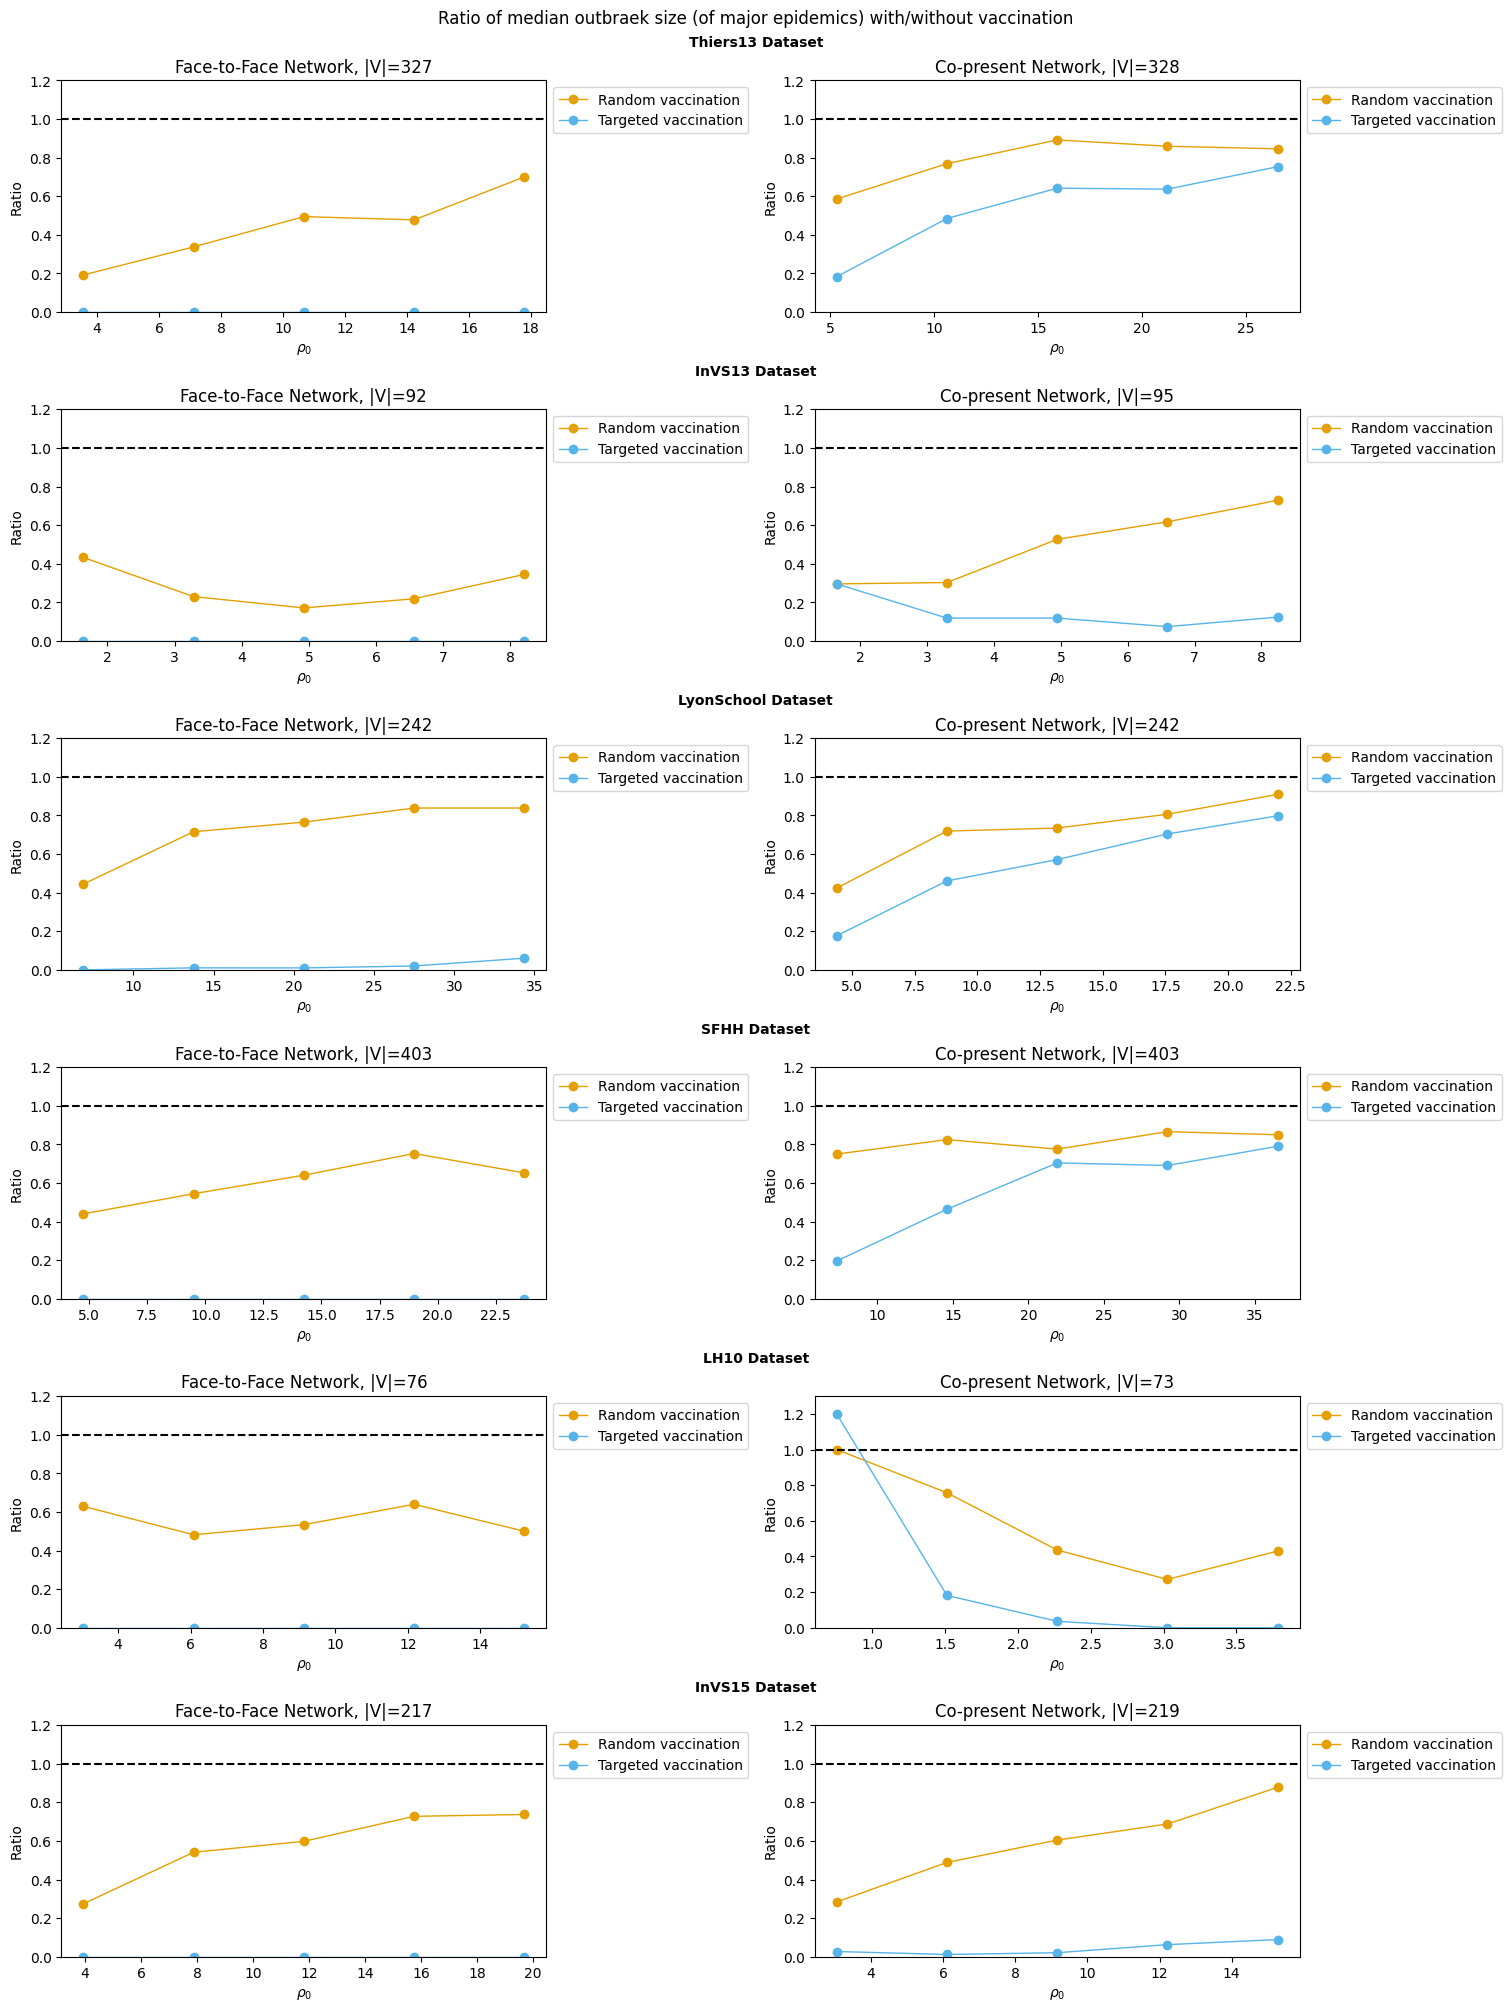

In [12]:
fig = plot_supfig_medians(data, ks)
plt.show()